In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr  
import yfinance as yfin
yfin.pdr_override()
import math
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense , LSTM, Dropout

In [2]:
import tensorflow as tf 
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


2022-12-06 10:41:46.999222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-06 10:41:46.999725: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-06 10:41:47.005146: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-06 10:41:47.005191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [3]:
df = pdr.get_data_yahoo('TTM'  , start = '2010-01-01' , end = '2022-11-30')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,18.090000,17.490000,17.570000,18.030001,2141700.0,16.901852
2010-01-05,17.900000,17.620001,17.780001,17.850000,2022500.0,16.733114
2010-01-06,18.010000,17.770000,17.900000,17.990000,2057800.0,16.864353
2010-01-07,17.629999,17.340000,17.389999,17.570000,2706800.0,16.470634
2010-01-08,17.559999,17.370001,17.559999,17.400000,1967200.0,16.311272
...,...,...,...,...,...,...
2022-11-23,25.930000,25.670000,25.670000,25.920000,400800.0,25.920000
2022-11-25,26.510000,26.160000,26.160000,26.389999,297500.0,26.389999
2022-11-28,26.500000,26.059999,26.320000,26.260000,622500.0,26.260000


In [4]:
df.shape

(3251, 6)

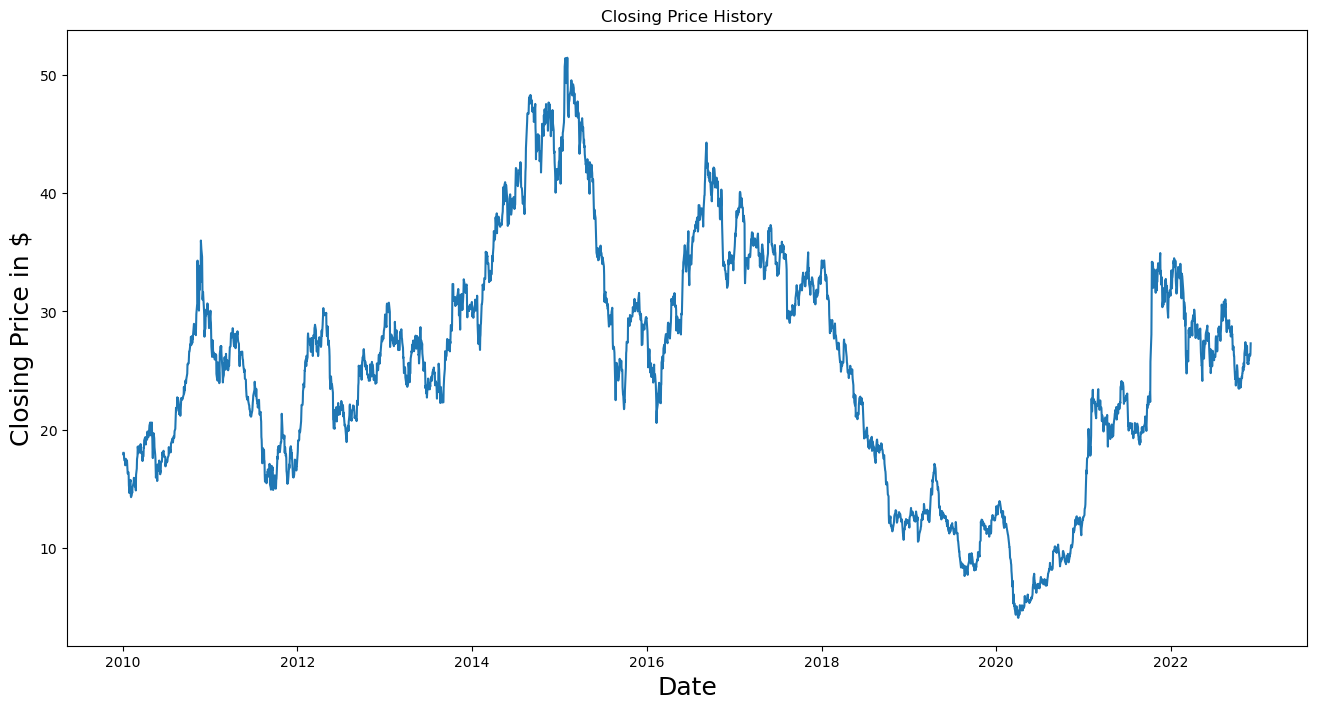

In [5]:
#Making a graph for the closing price
plt.figure(figsize=(16,8))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date' , fontsize = 18)
plt.ylabel('Closing Price in $' , fontsize = 18)
plt.show()

In [6]:
#Creating a new dataframe which only has the 'Close' block
data = df.filter(items = ['Close'])
print(data)
#Now we convert the dataframe object to a numpy array
dataset = data.values

#Getting the number of rows to train the model
training_data_len = math.ceil(len(dataset)*0.8)

training_data_len

                Close
Date                 
2010-01-04  18.030001
2010-01-05  17.850000
2010-01-06  17.990000
2010-01-07  17.570000
2010-01-08  17.400000
...               ...
2022-11-23  25.920000
2022-11-25  26.389999
2022-11-28  26.260000
2022-11-29  26.389999
2022-11-30  27.299999

[3251 rows x 1 columns]


2601

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.29436591],
       [0.29056763],
       [0.29352183],
       ...,
       [0.46803122],
       [0.4707744 ],
       [0.48997676]])

In [8]:
#Creating the Training Data Set
#Creating the Scaled Data Set
train_data = scaled_data[0:training_data_len, :] # : to get all columns

#Splitting the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60 , len(train_data)):
    x_train.append(train_data[i-60:i,0]) #contains(appends) 60 values from 0 to 59 , 0th column
    y_train.append(train_data[i,0]) #contains the 61st value, ie 60
    if i<=60: # just showing the training sets as an example
        print(x_train)
        print(y_train)
        print()
        
#this process is repeated, next time 1-60 (including) values are taken and 61th is y train

[array([0.29436591, 0.29056763, 0.29352183, 0.2846592 , 0.28107194,
       0.28043892, 0.27220931, 0.28107194, 0.28381516, 0.27980586,
       0.28107194, 0.27368641, 0.26376872, 0.25743829, 0.25997044,
       0.25490609, 0.23633677, 0.23148343, 0.2226208 , 0.24414432,
       0.24330026, 0.24604346, 0.21797847, 0.21523527, 0.21924457,
       0.22641908, 0.22304282, 0.23253851, 0.23401561, 0.24182316,
       0.24984174, 0.24435534, 0.23802489, 0.2422452 , 0.23359357,
       0.23464865, 0.22726314, 0.25532813, 0.26630092, 0.2831821 ,
       0.2861363 , 0.28909053, 0.30554968, 0.29373285, 0.30343952,
       0.30618274, 0.2987972 , 0.29753112, 0.29710909, 0.3042836 ,
       0.30998101, 0.29921924, 0.29373285, 0.29647603, 0.29373285,
       0.28634732, 0.27980586, 0.28845747, 0.28803543, 0.30449462])]
[0.30343951819384757]



In [9]:
#Converting the x_train and y_train into numpy arrays (used in LSTM model)
x_train,y_train = np.array(x_train) , np.array(y_train)
len(x_train)

2541

In [10]:
#Reshaping the data, because we need a 3D data 1424
x_train = np.reshape(x_train,(2541,60,1)) #samples, time-steps, features(closing price)
x_train.shape

(2541, 60, 1)

In [213]:
#Building the LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape = (60,1)))#50 = no of neurons , adding LSTM layer , 60=time step, 1 = feature

model.add(LSTM(50, return_sequences = True, ))

model.add(LSTM(50, return_sequences = False)) 

model.add(Dense(256))# 25 neurones densely connected neural network

model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(1))

In [11]:
model = Sequential()

model.add(LSTM(units=128,return_sequences=True,input_shape = (60,1)))
model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=32))

model.add(Dense(units=64, activation = 'relu'))
model.add(Dense(units=16, activation = 'relu'))
model.add(Dense(units=1))

model.summary()

2022-12-06 10:42:07.613047: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-06 10:42:07.613090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 131,553
Trainable params: 131,553
Non-trai

In [13]:
#Compile the model
#, metrics=['accuracy','mse']
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer = optimizer , loss = 'mean_squared_error') #using optimizer to reduce loss function

In [14]:
#Training the model
model.fit(x_train, y_train, batch_size = 15, epochs = 20) 

Epoch 1/20


2022-12-06 10:42:20.663161: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-06 10:42:21.755404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 10:42:21.945433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 10:42:22.078219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 10:42:22.177374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 10:42:22.385443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 10:42:22.592783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114

170/170 [==============================] - 11s 50ms/step - loss: 0.0097
Epoch 2/20
170/170 [==============================] - 8s 48ms/step - loss: 0.0014
Epoch 3/20
170/170 [==============================] - 8s 47ms/step - loss: 0.0013
Epoch 4/20
170/170 [==============================] - 8s 48ms/step - loss: 0.0010
Epoch 5/20
170/170 [==============================] - 8s 48ms/step - loss: 8.7601e-04
Epoch 6/20
170/170 [==============================] - 8s 47ms/step - loss: 9.1861e-04
Epoch 7/20
170/170 [==============================] - 8s 46ms/step - loss: 6.3983e-04
Epoch 8/20
170/170 [==============================] - 8s 47ms/step - loss: 5.9980e-04
Epoch 9/20
170/170 [==============================] - 8s 46ms/step - loss: 5.6549e-04
Epoch 10/20
170/170 [==============================] - 8s 46ms/step - loss: 6.5463e-04
Epoch 11/20
170/170 [==============================] - 8s 48ms/step - loss: 4.5959e-04
Epoch 12/20
170/170 [==============================] - 8s 47ms/step - loss: 3.

In [15]:
#Creating a testing data set
test_data = scaled_data[training_data_len - 60: , :] 
#Creating the datasets x_test and y_text
x_test = []
y_test = dataset[training_data_len: , :] #the values that we want our model to predict

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0]) # contains past 60 values and y_test contains the 61st value
    

In [16]:
#Converting the data to a numpy array
x_test = np.array(x_test)

In [17]:
#Reshaping the data from 2D to 3D
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] , 1)) #No of samples(row), no of time steps(cols), no of features

In [18]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #Unscaling the values

2022-12-06 10:45:46.463607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 10:45:46.528047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-06 10:45:46.621092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 3/21 [===>..........................] - ETA: 0s 

2022-12-06 10:45:46.717907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 35ms/step


/var/folders/by/vpx1dnsx5pg90s24q6mbhmmw0000gn/T/ipykernel_36563/4212190407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


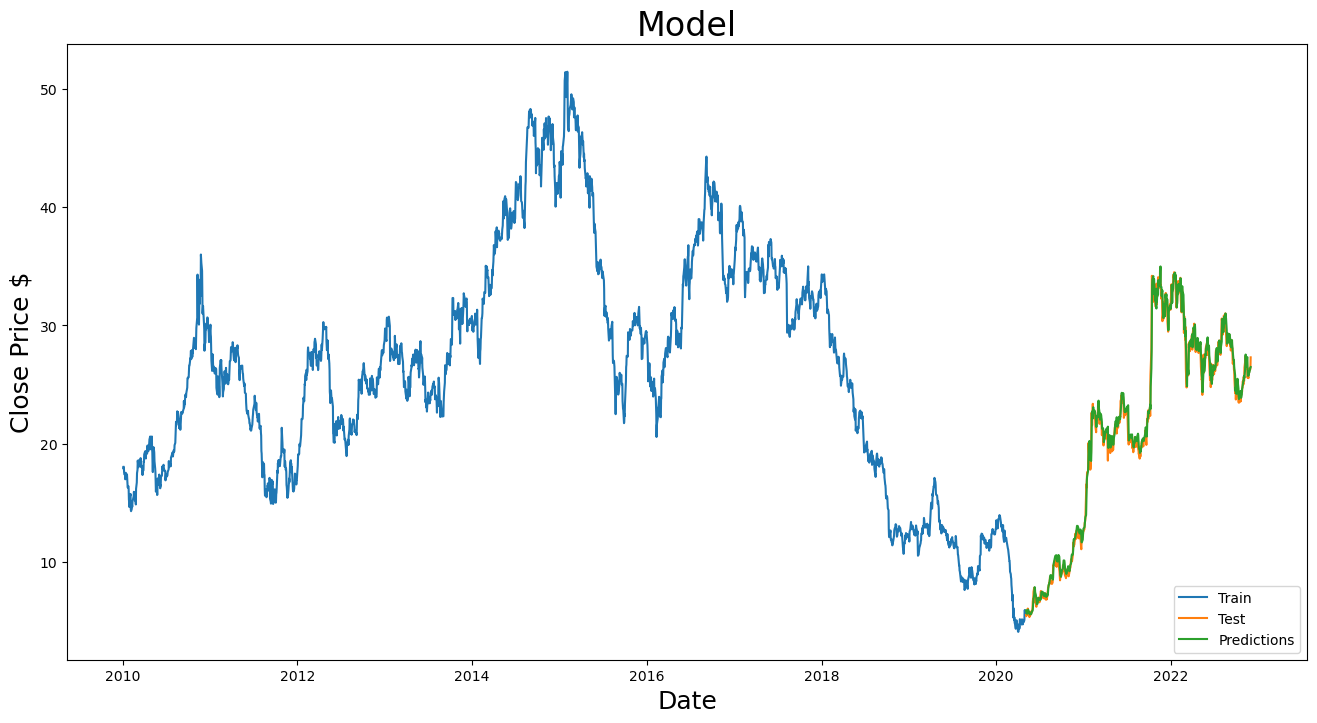

In [19]:
#Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions


plt.figure(figsize=(16,8))
plt.title('Model', fontsize=24)
plt.ylabel('Close Price $', fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close' , 'Predictions']])
plt.legend(['Train' , 'Test' , 'Predictions'] , loc='lower right')
plt.show()

In [21]:
#Performance Metrics for the model

#Root Mean Square Error
rmse_model = np.sqrt(np.mean(predictions - y_test)**2)
print("The Root Mean Squared Error for the model is : {:.5f}".format(rmse_model))

print("-------------------------------------------------------------------")

#Mean Absolute Error
mae_model = mean_absolute_error(y_test, predictions)
print("The Mean Absolute Error for the model is : {:.5f}".format(mae_model))

print("-------------------------------------------------------------------")

#R2 score the model
score = r2_score(valid['Close'], valid['Predictions'])
print("The R2 score for the model is : {:.4f}%".format(score*100))

The Root Mean Squared Error for the model is : 0.15899
-------------------------------------------------------------------
The Mean Absolute Error for the model is : 0.51833
-------------------------------------------------------------------
The R2 score for the model is : 99.2852%


In [22]:
#Showing the valid(actual) and predicted prices
print(valid)
#print(np.ndarray.flatten(y_test) - np.ndarray.flatten(predictions))
#print(np.ndarray.flatten(predictions))
#num = valid['Close'] - valid['Predictions']
#print(num)
#num1 = num/valid['Predictions']
#print(num1)
#print(len(valid['Close']))

                Close  Predictions
Date                              
2020-05-05   5.470000     5.885600
2020-05-06   5.390000     5.792556
2020-05-07   5.500000     5.668904
2020-05-08   5.550000     5.606412
2020-05-11   5.850000     5.610070
...               ...          ...
2022-11-23  25.920000    25.982615
2022-11-25  26.389999    26.050840
2022-11-28  26.260000    26.367365
2022-11-29  26.389999    26.415125
2022-11-30  27.299999    26.476400

[650 rows x 2 columns]


In [23]:
companies = {
    'Tickers': ['IOC.NS' , 'BALMLAWRIE.NS' , 'CHENNPETRO.NS' , 'OIL.NS' , 'ONGC.NS' , 'HYMTF' , 'M&MFIN.NS' , 'TTM' , 
                          'NSANY' , 'HMC' , 'IBN' , 'HDB' , 'PNB.NS' , 'CANBK.NS' , 'UNIONBANK.NS'],
    'Company Name': ['India Oil Corp.India' , 'Balmer Lawrie & Co. Ltd' , 'Chennai Petroleum Corporation Limited' , 
                 'Oil India Limited' , 'Oil and Natural Gas Corporation Limited' , 'Hyundai Motor Company' ,
                 'Mahindra & Mahindra' , 'Tata Motors Limited' , 'Nissan Motor Co.Ltd.' , 'Honda Motor Co. Ltd.' ,
                 'ICICI Bank Limited' , 'HDFC Bank Limited' , 'Punjab National Bank' , 'Canara Bank' , 'Union Bank of India'],
    'Type': ['OIL' , 'OIL' , 'OIL' , 'OIL' , 'OIL' , 'AUTOMOBILE' , 'AUTOMOBILE' ,  'AUTOMOBILE' ,  'AUTOMOBILE' , 
         'AUTOMOBILE' , 'BANK' , 'BANK' , 'BANK' , 'BANK' , 'BANK']}

Index = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

company = pd.DataFrame(companies , index = Index)

In [24]:
bold_start = '\033[1m'
bold_end   = '\033[0m'

class stocks:
    
    def __init__(self):
        pass
    
    def showData(self):
        print(bold_start , "                      ------WELCOME TO THE STOCK MARKET PREDICTOR------" , bold_end)
        print("")
        print("This app will provide you with the estimated price of the next day of any particular stock you desire!")
        print("")
        print("The companies supported by our model are :")
        dfStyler = company.style.set_properties(**{'text-align': 'left'})
        dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
        return company
        
obj1 = stocks()
obj1.showData()

                       ------WELCOME TO THE STOCK MARKET PREDICTOR------ 

This app will provide you with the estimated price of the next day of any particular stock you desire!

The companies supported by our model are :


,Tickers,Company Name,Type
1,IOC.NS,India Oil Corp.India,OIL
2,BALMLAWRIE.NS,Balmer Lawrie & Co. Ltd,OIL
3,CHENNPETRO.NS,Chennai Petroleum Corporation Limited,OIL
4,OIL.NS,Oil India Limited,OIL
5,ONGC.NS,Oil and Natural Gas Corporation Limited,OIL
6,HYMTF,Hyundai Motor Company,AUTOMOBILE
7,M&MFIN.NS,Mahindra & Mahindra,AUTOMOBILE
8,TTM,Tata Motors Limited,AUTOMOBILE
9,NSANY,Nissan Motor Co.Ltd.,AUTOMOBILE
10,HMC,Honda Motor Co. Ltd.,AUTOMOBILE


Enter company ticker whose past 30 days history you would like to see : TTM
Would you like to see the data in the form of a graph or a database? : database

                 High        Low       Open      Close   Volume  Adj Close
Date                                                                      
2022-04-01  29.230000  28.629999  28.680000  29.219999   710600  29.219999
2022-04-04  29.740000  29.410000  29.530001  29.690001   440700  29.690001
2022-04-05  30.330000  29.340000  30.000000  29.510000  1106200  29.510000
2022-04-06  29.820000  29.370001  29.510000  29.650000  1256000  29.650000
2022-04-07  29.510000  28.600000  29.250000  29.219999  2089200  29.219999
2022-04-08  30.459999  29.230000  29.309999  30.150000  1163200  30.150000
2022-04-11  29.850000  29.250000  29.570000  29.320000   824800  29.320000
2022-04-12  28.990000  28.200001  28.870001  28.309999   796700  28.309999
2022-04-13  28.139999  27.889999  28.049999  27.980000   534300  27.980000
2022-04-14  27.990

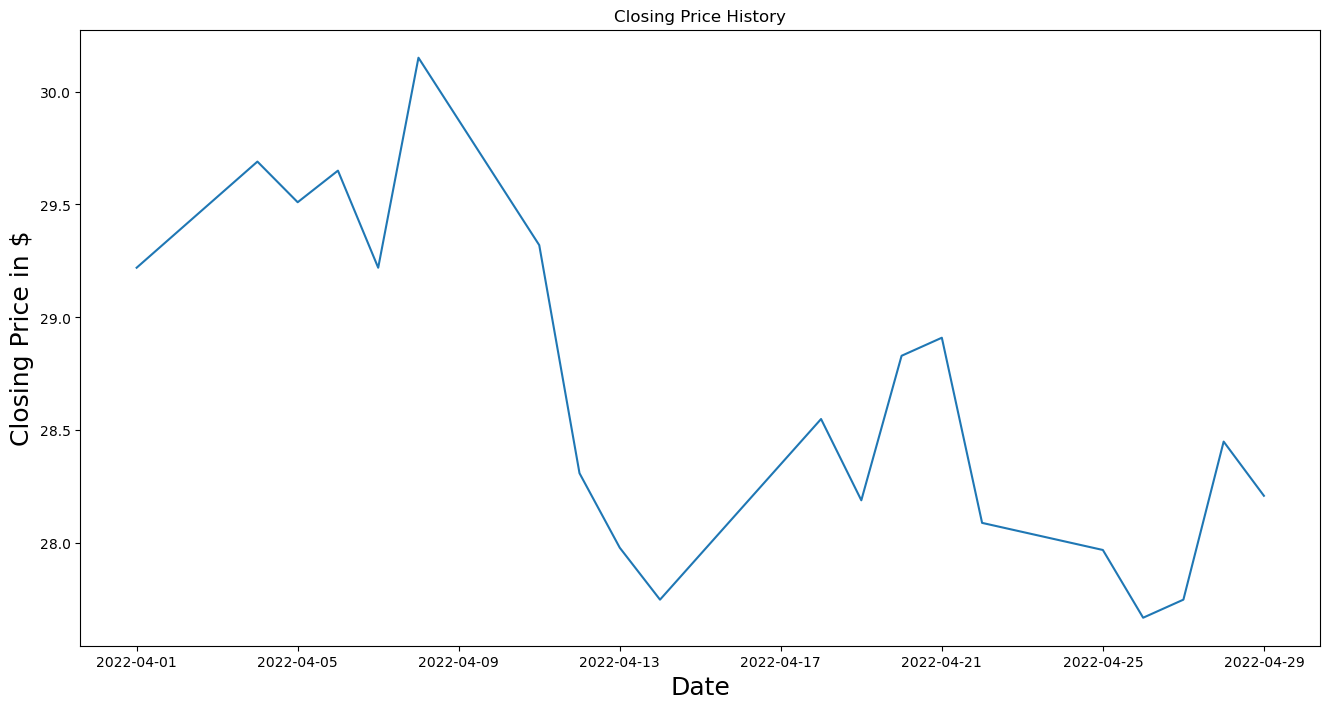


Would you like to view the data of any more companies? : no


In [25]:
class history:
    
    def __init__(self):
        pass
    
    def compName(self):
        self.comp = input("Enter company ticker whose past 30 days history you would like to see : ").upper()
          
    def show(self):
        dataFrame = pdr.DataReader(self.comp , data_source = 'yahoo' , start = '2022-04-01' , end = '2022-04-30')
        print(dataFrame)
        
    def getCompanyName(self):
        return self.comp
        
class historyGraph(history):
    
    def __init__(self):
        pass
    
    def show(self,com):
        self.com = com
        dataFrame = pdr.DataReader(self.com , data_source = 'yahoo' , start = '2022-04-01' , end = '2022-04-30')
        plt.figure(figsize=(16,8))
        plt.title('Closing Price History')
        plt.plot(dataFrame['Close'])
        plt.xlabel('Date' , fontsize = 18)
        plt.ylabel('Closing Price in $' , fontsize = 18)
        plt.show()
        
obj = history()
obj2 = historyGraph()

flag = 1
while (flag==1):
    obj.compName()
    mode = input("Would you like to see the data in the form of a graph or a database? : ").upper()
    print("")
    if(mode == "GRAPH"):
        obj2.show(obj.getCompanyName())
    else:
        obj.show()
    print("")
    answer = input("Would you like to view the data of any more companies? : ").upper()
    if(answer == "NO"):
        flag=0

In [26]:
class prediction:
    
    def __init__(self):
        pass
        
    def companyName(self):
        self.comp = input("Enter the company ticker whose stock price you would like to predict : ").upper()
        
    def dateToday(self):
        self.date1 = input("Enter the date of the current day : ")

    def dateTomorrow(self):
        self.date = input("Enter the date of the next day : ")
        
    def calculate(self):
        company_quote = pdr.DataReader(self.comp , data_source='yahoo' , start='2015-01-01' , end=self.date)

        new_df = company_quote.filter(['Close']) 
        last_60_days = new_df[-60:].values 
        last_60_days_scaled = scaler.transform(last_60_days)  
        X_test = []
        X_test.append(last_60_days_scaled)
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0] , X_test.shape[1] , 1))
        pred_price = model.predict(X_test)
        pred_price = scaler.inverse_transform(pred_price)
        self.pred = pred_price
        
    def show(self):
        print(f"The estimated price for {self.comp} on  {self.date}  is  {self.pred}")
        
    def invest(self):
        company_quote = pdr.DataReader(self.comp , data_source='yahoo' , start=self.date1)
        new_df = company_quote.filter(['Close'])
        pred_price1 = new_df['Close'][1]
        
        if pred_price1<self.pred:
            print(f"The price of {self.comp} on {self.date} is {pred_price1} and is lower than the predicted price -> should invest in the stock")
        else:
            print(f"The price of {self.comp} on {self.date} is {pred_price1} and is higher than the predicted price -> dont invest in this stock.")
        
pred = prediction()
pred.companyName()
pred.dateToday()
pred.dateTomorrow()
pred.calculate()
pred.show()
pred.invest()

Enter the company ticker whose stock price you would like to predict : TTM
Enter the date of the current day : 3-12-2022
Enter the date of the next day : 4-12-2022
1/1 [==============================] - 0s 248ms/step
The estimated price for TTM on  4-12-2022  is  [[28.597807]]
The price of TTM on 4-12-2022 is 27.600000381469727 and is lower than the predicted price -> should invest in the stock
